In [5]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [3]:
# ClinicalBERT model name
model_name = 'emilyalsentzer/Bio_ClinicalBERT'

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

c:\Users\lbm852\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lbm852\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


c:\Users\lbm852\Anaconda3\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [7]:
# Load your CSV data
df = pd.read_csv(r'C:\Users\lbm852\Documents\joao\code_python\PillProphet\clinical_trials_data_preprocessed.csv')

# Load tokenizer and model
model_name = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Tokenize text
encoded_inputs = tokenizer(
    df['combined_text'].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

# Create DataLoader
dataset = TensorDataset(
    encoded_inputs['input_ids'],
    encoded_inputs['attention_mask']
)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size)

# Extract embeddings
all_cls_embeddings = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc='Processing Batches'):
        input_ids, attention_mask = [t.to(device) for t in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state
        cls_embeddings = last_hidden_states[:, 0, :]  # [CLS] token
        all_cls_embeddings.append(cls_embeddings.cpu().numpy())

# Concatenate embeddings
import numpy as np
all_cls_embeddings = np.concatenate(all_cls_embeddings, axis=0)

# Add embeddings to DataFrame
df_embeddings = pd.DataFrame(all_cls_embeddings)
df_embeddings.columns = [f'embedding_{i}' for i in range(all_cls_embeddings.shape[1])]
df = pd.concat([df.reset_index(drop=True), df_embeddings], axis=1)

# Save DataFrame with embeddings
df.to_csv('clinical_trials_with_embeddings.csv', index=False)

C:\Users\lbm852\AppData\Local\Temp/ipykernel_22512/3025118630.py:2: DtypeWarning: Columns (179,180,214,228,229,235,236,237,238,239,241) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\lbm852\Documents\joao\code_python\PillProphet\clinical_trials_data_preprocessed.csv')
Processing Batches: 100%|██████████| 398/398 [2:48:44<00:00, 25.44s/it]  


In [9]:
# Load the data
df = pd.read_csv(r'C:\Users\lbm852\Documents\joao\code_python\PillProphet\clinical_trials_with_embeddings.csv')

# Verify that the data has been loaded correctly
print(df.head())

C:\Users\lbm852\AppData\Local\Temp/ipykernel_22512/403026383.py:2: DtypeWarning: Columns (72,74,75,76,84,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,163,174,175,176,179,180,181,182,183,184,185,186,187,189,190,191,192,195,198,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,235,236,237,238,239,241) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\lbm852\Documents\joao\code_python\PillProphet\clinical_trials_with_embeddings.csv')


                       required_header_download_date  \
0  ClinicalTrials.gov processed this data on Octo...   
1  ClinicalTrials.gov processed this data on Octo...   
2  ClinicalTrials.gov processed this data on Octo...   
3  ClinicalTrials.gov processed this data on Octo...   
4  ClinicalTrials.gov processed this data on Octo...   

                        required_header_link_text  \
0  Link to the current ClinicalTrials.gov record.   
1  Link to the current ClinicalTrials.gov record.   
2  Link to the current ClinicalTrials.gov record.   
3  Link to the current ClinicalTrials.gov record.   
4  Link to the current ClinicalTrials.gov record.   

                               required_header_url  id_info_org_study_id  \
0  https://clinicaltrials.gov/ct2/show/NCT00000102  NCRR-M01RR01070-0506   
1  https://clinicaltrials.gov/ct2/show/NCT00000104  NCRR-M01RR00400-0587   
2  https://clinicaltrials.gov/ct2/show/NCT00000105             2002LS032   
3  https://clinicaltrials.gov/ct2/show/N

In [10]:
import numpy as np

# Identify the embedding columns
embedding_columns = [col for col in df.columns if col.startswith('embedding_')]

# Extract the embeddings
embeddings = df[embedding_columns].values  # Shape: (num_samples, 768)

In [11]:
from sklearn.manifold import TSNE

# Reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Alternatively, for 3D visualization
# tsne = TSNE(n_components=3, random_state=42)
# embeddings_3d = tsne.fit_transform(embeddings)

c:\Users\lbm852\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lbm852\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lbm852\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lbm852\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

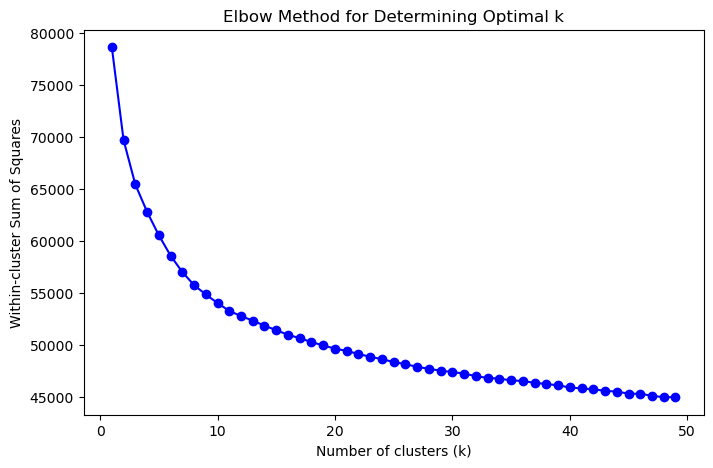

In [27]:
from sklearn.cluster import KMeans

wcss = []
k_values = range(1, 50)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares')
plt.title('Elbow Method for Determining Optimal k')
plt.show()


In [28]:
from sklearn.cluster import KMeans

# Decide on the number of clusters (k)
k = 10  # You can experiment with different values

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(embeddings)

# Get cluster labels
cluster_labels = kmeans.labels_

c:\Users\lbm852\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
from sklearn.cluster import AgglomerativeClustering

# Initialize and fit Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=k)
cluster_labels = agg_clustering.fit_predict(embeddings)

In [22]:
from sklearn.cluster import DBSCAN

# Initialize and fit DBSCAN
dbscan = DBSCAN(eps=500, min_samples=2)
cluster_labels = dbscan.fit_predict(embeddings)

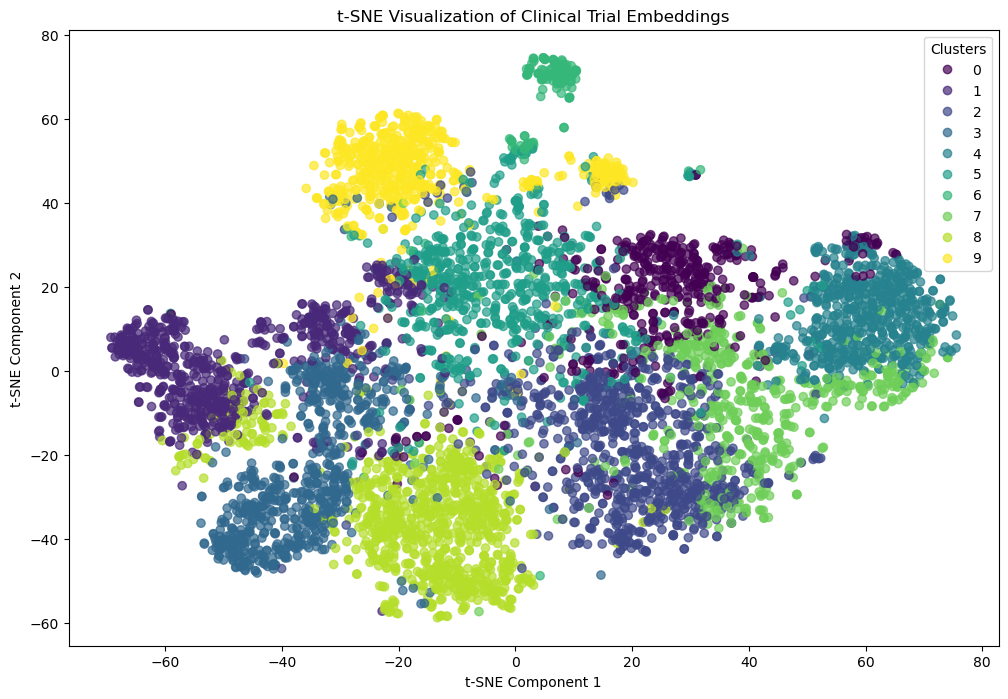

In [29]:
import matplotlib.pyplot as plt

# Create a DataFrame for plotting
plot_df = pd.DataFrame()
plot_df['x'] = embeddings_2d[:, 0]
plot_df['y'] = embeddings_2d[:, 1]
plot_df['cluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(plot_df['x'], plot_df['y'], c=plot_df['cluster'], cmap='viridis', alpha=0.7)
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.title('t-SNE Visualization of Clinical Trial Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [30]:
# Add cluster labels to the DataFrame
df['cluster'] = cluster_labels

# Group by cluster and examine text fields
for cluster in sorted(df['cluster'].unique()):
    print(f"\nCluster {cluster}:")

    # Get trials in the cluster
    cluster_df = df[df['cluster'] == cluster]

    # For example, show the most common keywords
    keywords = cluster_df['keyword'].dropna().str.cat(sep='; ').split('; ')
    keyword_counts = pd.Series(keywords).value_counts().head(10)
    print("Top Keywords:")
    print(keyword_counts)

    # You can also examine conditions, interventions, etc.


Cluster 0:
Top Keywords:
breast cancer                                                                                             2
['Acquired Immunodeficiency Syndrome', 'AIDS-Related Complex']                                            2
['colon cancer', 'rectal cancer']                                                                         2
['substance misuse', 'intimate partner violence', 'domestic violence', 'treatment']                       1
['adolescents', 'randomized controlled trial', 'PTSD', 'ACE', 'depression', 'anxiety']                    1
['Autism spectrum disorder', 'Lactococcus lactis', 'Human Study']                                         1
['ECG', 'heart rhythm', 'electrical conduction']                                                          1
['community-led', 'COVID-19', 'trust', 'vaccine hesitancy', 'peer mentor', 'community advisory board']    1
['Rehabilitation', 'Spine fracture', 'Exercise', 'Physical functioning']                                  1
['

In [31]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# For each cluster
for cluster in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster]
    texts = cluster_df['combined_text'].dropna().tolist()
    
    # Vectorize text data
    vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
    dtm = vectorizer.fit_transform(texts)
    
    # Apply LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)
    
    # Display topics
    print(f"\nCluster {cluster} Topics:")
    for idx, topic in enumerate(lda.components_):
        print(f"Topic {idx}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Cluster 0 Topics:
Topic 0:
['years', 'age', 'genetic', 'participants', 'criteria', 'family', 'activity', 'physical', 'exercise', 'children']
Topic 1:
['criteria', 'therapy', 'weeks', 'clinical', 'disease', 'pain', 'hiv', 'treatment', 'patient', 'patients']
Topic 2:
['disease', 'life', 'ii', 'disorder', 'depression', 'therapy', 'stage', 'patients', 'treatment', 'cancer']
Topic 3:
['studies', 'criteria', 'screening', 'history', 'disease', 'blood', 'research', 'subjects', 'protocol', 'patients']
Topic 4:
['mental', 'criteria', 'program', 'scale', 'self', 'group', 'participants', 'care', 'health', 'intervention']

Cluster 1 Topics:
Topic 0:
['protocol', 'days', 'iv', 'response', 'greater', 'receive', 'antineoplaston', 'treatment', 'weeks', 'months']
Topic 1:
['months', 'iii', 'chemotherapy', 'radiotherapy', 'surgery', 'ii', 'prostate', 'stage', 'specified', 'cancer']
Topic 2:
['iii', 'carcinoma', 'ii', 'iv', 'leukemia', 'recurrent', 'adult', 'cell', 'stage', 'lymphoma']
Topic 3:
['ii', 'r